In [67]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import powerlaw

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from tslearn.clustering import TimeSeriesKMeans
from tslearn.svm import TimeSeriesSVC

%matplotlib inline

In [68]:
tdata = pd.read_csv("CleanTimeStampsDurationLabels.csv", names=["id", "Tag","Start","End","Duration"], skiprows=1)
print(tdata.shape)
print(tdata.head())

(161154, 5)
   id           Tag          Start            End  Duration
0   0  Jake Bentley  9/3/2017 0:00  9/3/2017 1:00         1
1   1      NC State  9/3/2017 0:00  9/3/2017 1:00         1
2   2       Broncos  9/3/2017 0:00  9/3/2017 1:00         1
3   3  Jim McElwain  9/3/2017 0:00  9/3/2017 1:00         1
4   4      Ty Isaac  9/3/2017 0:00  9/3/2017 1:00         1


In [69]:
wdata = pd.read_csv("wiki_timeseries_full.csv")
print(wdata.shape)
print(wdata.head())

(103951, 36)
   id      raw_topic                         i_topic                 date  \
0   0    John O'Korn                     John O'Korn  2017-09-03 00:00:00   
1   1       Harbaugh                    Jim Harbaugh  2017-09-03 00:00:00   
2   3     Tom Herman  Tom Herman (American football)  2017-09-03 00:00:00   
3   5  Justin Turner                   Justin Turner  2017-09-03 00:00:00   
4   6     Lance Lynn                      Lance Lynn  2017-09-03 00:00:00   

     t-15    t-14    t-13    t-12    t-11    t-10  ...     t+7     t+8  \
0    61.0    78.0    71.0    50.0    54.0    62.0  ...   268.0   116.0   
1  1077.0  1175.0  1339.0  1325.0  1141.0  1214.0  ...  5001.0  2922.0   
2   710.0   590.0   833.0   860.0   712.0   738.0  ...  2269.0   795.0   
3   869.0   520.0   601.0   897.0   872.0   635.0  ...   476.0   196.0   
4   204.0  1389.0   952.0   153.0   292.0   102.0  ...    51.0    40.0   

      t+9    t+10    t+11    t+12    t+13     t+14    t+15         mean  
0    

In [70]:
duration_counts = np.bincount(tdata["Duration"])
duration_list = np.arange(duration_counts.shape[0])

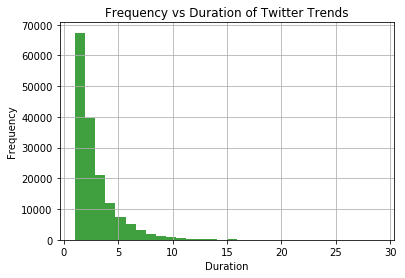

In [71]:
n, bins, patches = plt.hist(tdata["Duration"], bins=duration_counts.shape[0], facecolor='g', alpha=0.75)
plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.title('Frequency vs Duration of Twitter Trends')
plt.grid(True)
plt.show()

Hmm, looks like it might follow a power law

C:\Users\Harrison\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


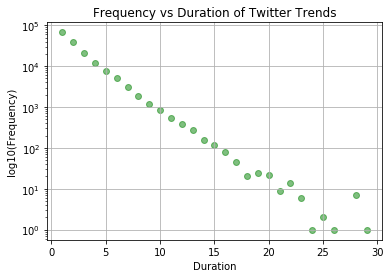

In [72]:
log_freq = np.log10(duration_counts)

masked_freq = np.ma.masked_where(duration_counts==0, duration_counts)
masked_duration_list = np.ma.masked_where(duration_counts==0, duration_list)

fig = plt.figure()
ax = plt.gca()
ax.scatter(masked_duration_list, masked_freq, c='g', alpha=0.5)
ax.set_yscale('log')
plt.xlabel('Duration')
plt.ylabel('log10(Frequency)')
plt.title('Frequency vs Duration of Twitter Trends')
plt.grid(True)
plt.show()

In [73]:
powerlaw_fit = powerlaw.Fit(duration_counts, discrete=True)
print(powerlaw_fit.power_law.alpha)
print(powerlaw_fit.power_law.xmin)
R, p = powerlaw_fit.distribution_compare('power_law', 'lognormal')
print(R)
print(p)

1.2382058774061746
6.0
-2.3541664194712975
0.1974352269344547


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
C:\Users\Harrison\Anaconda3\lib\site-packages\powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
C:\Users\Harrison\Anaconda3\lib\site-packages\powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


C:\Users\Harrison\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


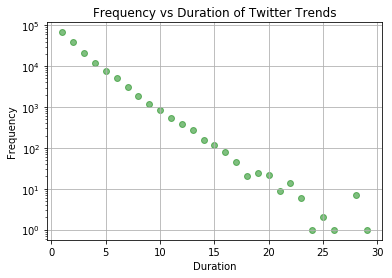

In [74]:
m, b = np.polyfit(masked_duration_list, np.log10(masked_freq), 1)

fig = plt.figure()
ax = plt.gca()
ax.scatter(masked_duration_list, masked_freq, c='g', alpha=0.5)
ax.set_yscale('log')
plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.title('Frequency vs Duration of Twitter Trends')
plt.grid(True)
plt.show()

Maybe pageviews follows a pattern too?

In [75]:
merged_data = wdata.merge(tdata, on=["id"],how='left')
print(merged_data.shape)
print(merged_data.head())

(103951, 40)
   id      raw_topic                         i_topic                 date  \
0   0    John O'Korn                     John O'Korn  2017-09-03 00:00:00   
1   1       Harbaugh                    Jim Harbaugh  2017-09-03 00:00:00   
2   3     Tom Herman  Tom Herman (American football)  2017-09-03 00:00:00   
3   5  Justin Turner                   Justin Turner  2017-09-03 00:00:00   
4   6     Lance Lynn                      Lance Lynn  2017-09-03 00:00:00   

     t-15    t-14    t-13    t-12    t-11    t-10  ...    t+11    t+12  \
0    61.0    78.0    71.0    50.0    54.0    62.0  ...    60.0    73.0   
1  1077.0  1175.0  1339.0  1325.0  1141.0  1214.0  ...  1978.0  1744.0   
2   710.0   590.0   833.0   860.0   712.0   738.0  ...   515.0   790.0   
3   869.0   520.0   601.0   897.0   872.0   635.0  ...   568.0   272.0   
4   204.0  1389.0   952.0   153.0   292.0   102.0  ...    80.0    71.0   

     t+13     t+14    t+15         mean              Tag          Start  \
0   

In [76]:
max_views = np.max(merged_data[["t-1", "t0", "t+1"]], axis=1)
median_views = np.nanmedian(merged_data[["t-1", "t0", "t+1"]], axis=1)

C:\Users\Harrison\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


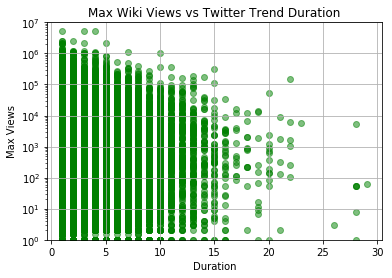

In [77]:

fig = plt.figure()
ax = plt.gca()
ax.scatter(merged_data["Duration"], max_views - median_views, c='g', alpha=0.5)
ax.set_yscale('log')
plt.xlabel('Duration')
plt.ylabel('Max Views')
plt.title('Max Wiki Views vs Twitter Trend Duration')
plt.grid(True)
ax.set_ylim([1,10**7])
plt.show()

In [78]:
merged_data = merged_data.dropna()
#print(merged_data.iloc[:,4:35])
avg_spike = np.zeros(duration_list.shape[0])
for i in range(duration_list.shape[0]):
    temp_df = merged_data[merged_data.Duration.isin([duration_list[i]])]
    max_mean = np.max(temp_df.iloc[:,4:35], axis = 1) - np.median(temp_df.iloc[:,4:35], axis = 1)
    avg_spike[i] = np.mean(max_mean)
print(avg_spike)

[           nan 19318.58269827 17221.65234596 17806.79591502
 19664.63437935 20311.26522528 15638.35564585 17432.48327606
 16815.88231917 15142.28520499 19412.46616541 15891.89018088
 17157.51075269 16502.64748201 12278.52054795 13715.46296296
  5196.08823529  9195.54545455  6231.33333333  5710.18181818
 28494.92307692  7572.         48976.          5783.
            nan            nan   655.                    nan
  2002.2          571.        ]


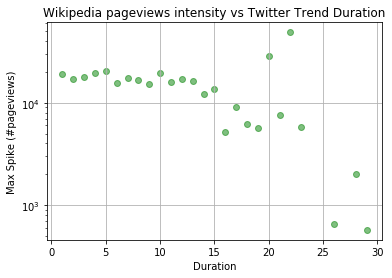

In [79]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(duration_list, avg_spike, c='g', alpha=0.5)
ax.set_yscale('log')
# ax.set_xscale('log')
plt.xlabel('Duration')
plt.ylabel('Max Spike (#pageviews)')
plt.title('Wikipedia pageviews intensity vs Twitter Trend Duration')
plt.grid(True)
plt.show()

Try some algorithms from tslearn

In [80]:
ts_15 = merged_data.iloc[:,4:19]
print(ts_15.head())

     t-15    t-14    t-13    t-12    t-11    t-10     t-9     t-8     t-7  \
0    61.0    78.0    71.0    50.0    54.0    62.0    60.0    36.0    35.0   
1  1077.0  1175.0  1339.0  1325.0  1141.0  1214.0  1272.0  1124.0  1399.0   
2   710.0   590.0   833.0   860.0   712.0   738.0   685.0   887.0  1102.0   
3   869.0   520.0   601.0   897.0   872.0   635.0   383.0   732.0   598.0   
4   204.0  1389.0   952.0   153.0   292.0   102.0    88.0    62.0   252.0   

      t-6     t-5     t-4     t-3     t-2      t-1  
0   102.0   191.0    83.0    84.0   143.0   5339.0  
1  1983.0  2292.0  2682.0  2240.0  2530.0  14722.0  
2   733.0   872.0   825.0  1123.0  1957.0  18617.0  
3   296.0   245.0   577.0   453.0   182.0    669.0  
4    99.0    75.0   226.0   151.0   110.0    370.0  


In [81]:
ts_list = ts_15.values.tolist()
duration = merged_data["Duration"]

Scale the time series to mean=0, var=1

In [82]:
ts_scaled = TimeSeriesScalerMeanVariance().fit_transform(ts_list)

In [83]:
X_train, X_test, y_train, y_test = train_test_split(ts_scaled, duration, test_size=0.25, random_state=42)

In [84]:
nc = 24
km = TimeSeriesKMeans(n_clusters=nc, verbose=True, random_state=42)
y_pred = km.fit_predict(X_train)
sz = X_train.shape[1]

8.652 --> 6.571 --> 6.411 --> 6.345 --> 6.309 --> 6.287 --> 6.274 --> 6.266 --> 6.261 --> 6.258 --> 6.255 --> 6.253 --> 6.252 --> 6.251 --> 6.250 --> 6.249 --> 6.249 --> 6.249 --> 6.248 --> 6.248 --> 6.247 --> 6.247 --> 6.246 --> 6.246 --> 6.245 --> 6.244 --> 6.244 --> 6.243 --> 6.241 --> 6.239 --> 6.237 --> 6.234 --> 6.231 --> 6.228 --> 6.226 --> 6.224 --> 6.223 --> 6.222 --> 6.221 --> 6.221 --> 6.221 --> 6.220 --> 6.220 --> 6.220 --> 6.219 --> 6.218 --> 6.218 --> 6.216 --> 6.215 --> 6.214 --> 


Cluster max twitter duration:  28.0


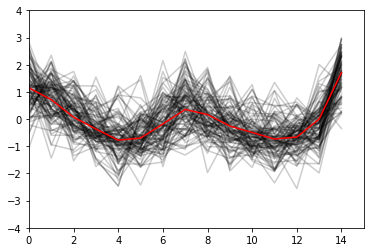

Cluster max twitter duration:  15.0


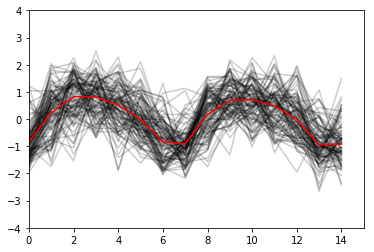

Cluster max twitter duration:  19.0


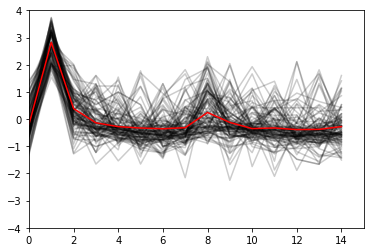

Cluster max twitter duration:  22.0


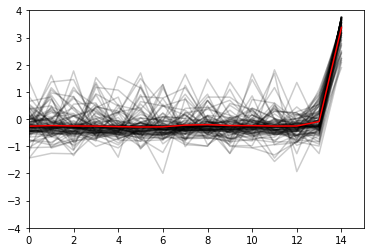

Cluster max twitter duration:  23.0


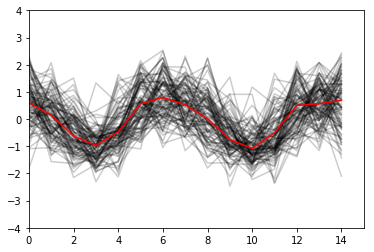

Cluster max twitter duration:  16.0


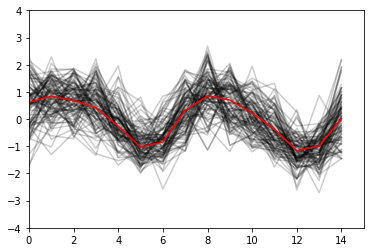

Cluster max twitter duration:  20.0


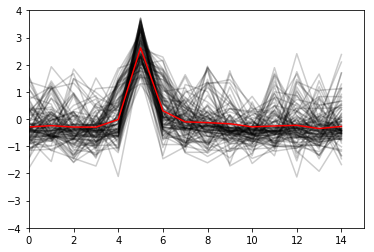

Cluster max twitter duration:  19.0


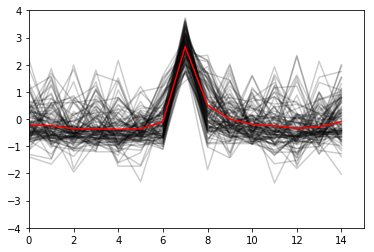

Cluster max twitter duration:  20.0


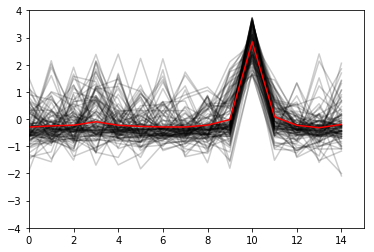

Cluster max twitter duration:  17.0


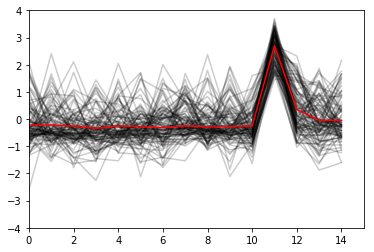

Cluster max twitter duration:  22.0


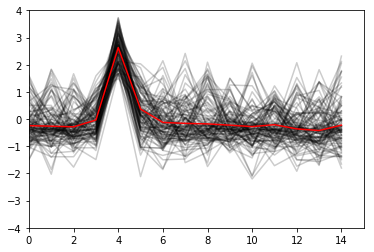

Cluster max twitter duration:  20.0


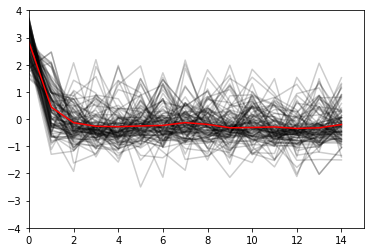

Cluster max twitter duration:  15.0


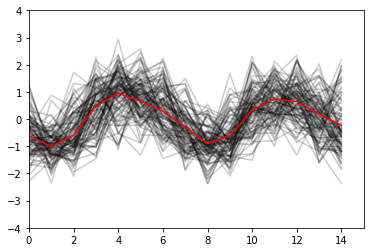

Cluster max twitter duration:  19.0


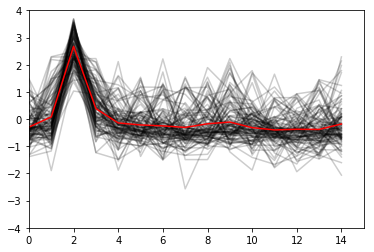

Cluster max twitter duration:  22.0


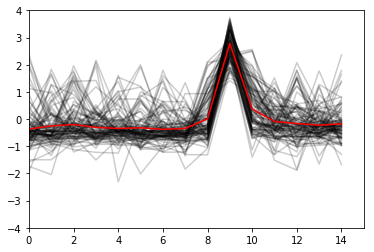

Cluster max twitter duration:  15.0


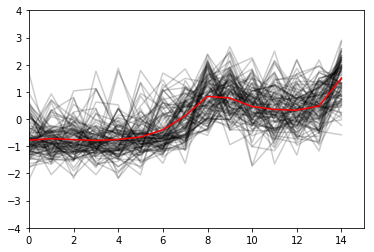

Cluster max twitter duration:  22.0


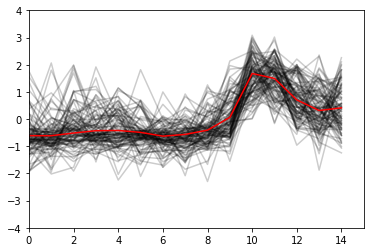

Cluster max twitter duration:  18.0


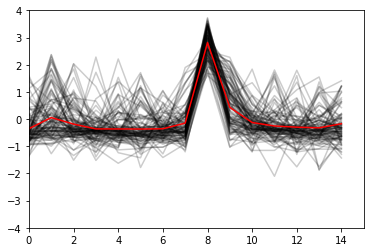

Cluster max twitter duration:  21.0


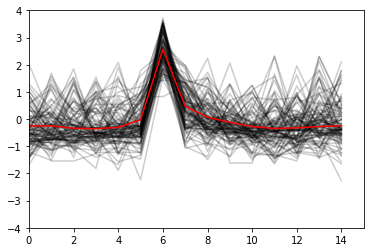

Cluster max twitter duration:  17.0


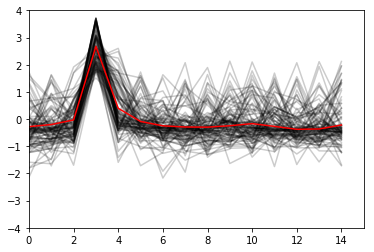

Cluster max twitter duration:  22.0


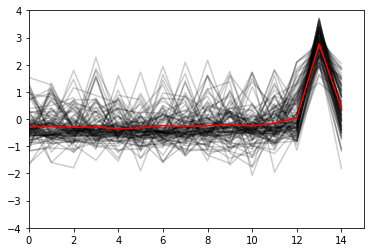

Cluster max twitter duration:  19.0


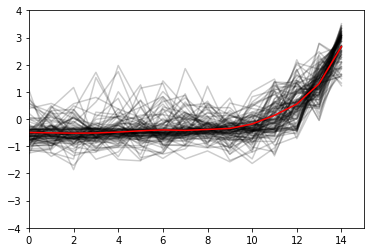

Cluster max twitter duration:  21.0


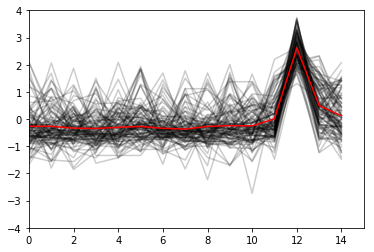

Cluster max twitter duration:  29.0


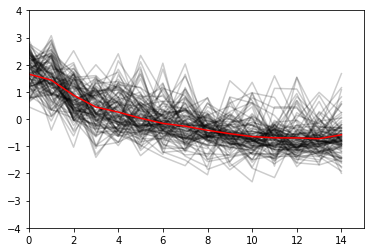

In [85]:
#plt.figure()
for yi in range(nc):
    #plt.subplot(nc, 1, yi + 1)
    plt.figure()
    i = 0
    for xx in X_train[y_pred == yi]:
        i += 1
        plt.plot(xx.ravel(), "k-", alpha=.2)
        #Just show the first 100 for readability
        if i > 100:
            break
            
    mu = np.max(y_train[y_pred == yi])
    print("Cluster max twitter duration: ", (mu))
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.show()